# [DeepLearning] [3] 파이토치 - 선형 회귀 모델

NBA 데이터의 경우 사용한 데이터의 중심이 원점($x$(키)=0, $y$(윙스팬)=0)으로부터 멀리 떨어져 있어서 경사하강법을 통해 파라미터를 구했을 때 OLS를 통해 구한 결과에 비해서 최적의 파라미터를 구하지 못했던 것을 확인할 수 있었습니다. 표준화를 진행하고, 이후에 경사하강법을 실행해보세요.

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [25]:
def ordinary_least_squares(x, y):
    N = len(x)
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    m = ((x - mean_x) * (y - mean_y)).sum() / ((x - mean_x)**2).sum()
    b = mean_y - m * mean_x
    return m, b

def gradient_step(tensors, learning_rate):
    if isinstance(tensors, torch.Tensor):
        tensors = [tensors]

    for t in tensors:
        if t.grad is not None:
            t.data -= learning_rate * t.grad
            t.grad.zero_()

def mean_squared_error(y_pred, y_true):
    mse = torch.mean((y_pred - y_true) ** 2)
    return mse

def graph_linear_regression_mse(
    x,
    y,
    trajectory=None,
    m_scale=10,
    b_scale=10,
    sample_density=500,
):

    def mse(x, y, m, b):
        x = x[:, np.newaxis]

        m = np.atleast_1d(m)
        b = np.atleast_1d(b)
        return ((x * m[None] + b[None] - y) ** 2).mean(axis=1)

    A = np.vstack([x, np.ones(len(x))]).T
    m_opt, b_opt = np.linalg.lstsq(A, y, rcond=None)[0]
    l_opt = mse(x, y, m_opt, b_opt)

    center_m = m_opt
    center_b = b_opt

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    ax.scatter(
        [m_opt],
        [b_opt],
        l_opt,
        c="black",
        marker="o",
        s = 50,
        zorder=3,
        #markersize=7,
    )

    m_series = np.linspace(center_m - m_scale, center_m + m_scale, sample_density)
    b_series = np.linspace(
        center_b - b_scale, center_b + b_scale, sample_density
    ).reshape(-1, 1)

    # Z = (b_series + x.reshape(-1, 1, 1) * m_series) - y.reshape(-1, 1, 1)
    # Z = np.mean(Z ** 2, axis=0)

    M, B = np.meshgrid(m_series, b_series)

    X_flattened = x[:, np.newaxis].flatten()
    Y_flattened = y[:, np.newaxis].flatten()

    Z = np.zeros_like(M)

    m_series, b_series = np.meshgrid(m_series, b_series)
    ax.set_xlabel("Slope: m")
    ax.set_ylabel("Intercept: b")
    ax.set_zlabel("MSE Loss")
    ax.ticklabel_format(style="sci", scilimits=(-1, 2))
    ax.dist = 11
    surf = ax.plot_surface(m_series, b_series, Z, cmap=plt.get_cmap("GnBu"))

    if trajectory is not None:
        trajectories = np.atleast_2d(trajectory)
        if trajectories.ndim == 2:
            trajectories = trajectories[np.newaxis]
        for trajectory in trajectories:
            m_values, b_values = trajectory.T
            l_values = ((x * m_values[:, None] + b_values[:, None] - y) ** 2).mean(
                axis=1
            )
            ax.plot(
                m_values,
                b_values,
                l_values,
                marker="*",
                c='red',
                zorder=3,
                markersize=7,
            )
    return fig, ax

1. torch.nn.Module을 상속받아 m과 b 파라미터를 가지며, forward 메서드가 y = m * x + b를 계산하는 LinearModel 클래스를 구현하세요. 또한, m과 b 파라미터는 -10에서 10 사이의 균일 분포로 초기화되어야 합니다.

In [17]:
class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.m = nn.Parameter(torch.FloatTensor(1).uniform_(-10,10))
        self.b = nn.Parameter(torch.FloatTensor(1).uniform_(-10,10))

    def forward(self, x):
        #self.expression()
        return self.m * x + self.b

    def parameters(self):
        return [self.m,self.b]

model = LinearModel()

2. nba_draft.csv 데이터를 불러오세요.

In [5]:
df = pd.read_csv('/content/drive/MyDrive/nba_draft.csv')

In [6]:
df.head()

,player,height_no_shoes,height_with_shoes,wingspan,weight
0,Zach Collins,82.25,84.00,85.00,232.0
1,Luke Kennard,76.50,77.50,77.25,196.0
2,Donovan Mitchell,73.25,75.00,82.00,211.0
3,Bam Adebayo,80.75,81.75,86.75,243.0
4,Justin Patton,82.00,83.25,87.00,229.0


3. draft_data 데이터프레임의 height_no_shoes 열과 wingspan 열을 각각 height와 wingspan 변수에 저장하고, 이를 이용해 ordinary_least_squares 함수를 통해 기울기 m과 절편 b를 계산하세요. 또한, height 변수의 최솟값과 최댓값 사이에서 1000개의 점을 생성하여 x 변수에 저장하세요.

In [7]:
height = df['height_no_shoes'].values
wingspan = df['wingspan'].values

m, b = ordinary_least_squares(height,wingspan)

print(f"slope(m): {m}")
print(f"intercept(b): {b}")

x = np.linspace(height.min(), height.max(), 1000)

slope(m): 0.9361087076221192
intercept(b): 9.982270444951368


4. 데이터의 평균을 0, 표준편차를 1로 맞추는 표준화를 위해 주어진 배열 x를 입력받아, 배열의 각 요소에서 평균을 빼고 표준 편차로 나눈 값을 반환하는 함수를 작성하세요.

In [8]:
def norm(x):
    return (x - x.mean()) / x.std()

5. 키 데이터와 윙스팬 데이터를 표준화시키세요.

In [9]:
normed_height = norm(height)
normed_wingspan = norm(wingspan)

6. 표준화된 데이터를 그래프로 나타내세요.

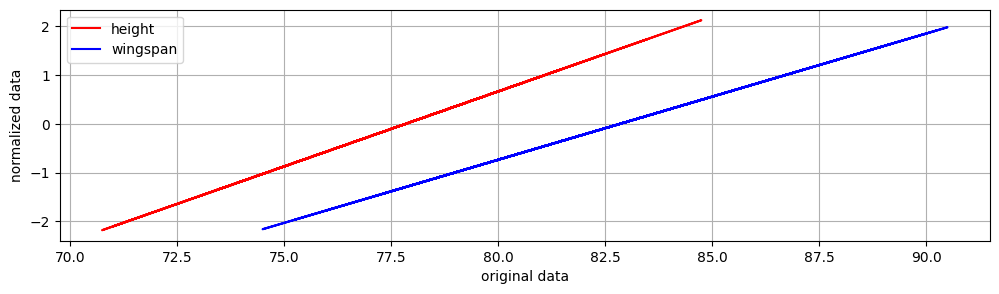

In [10]:
plt.figure(figsize = (12,3))
plt.plot(height, normed_height, linestyle = '-', color = 'r', label = 'height')
plt.plot(wingspan, normed_wingspan, linestyle = '-', color = 'b', label = 'wingspan')
plt.xlabel('original data')
plt.ylabel('normalized data')
plt.legend()
plt.grid()
plt.show()

7. 정규화된 normed_height와 normed_wingspan 배열을 각각 torch.float32 데이터 타입의 torch.tensor로 변환하세요.

In [11]:
normed_height = torch.FloatTensor(normed_height)
normed_wingspan = torch.tensor(normed_wingspan, dtype = torch.float32)

8. 빈 리스트 trajectory, loss_values, m_values, b_values를 생성하고, LinearModel 클래스의 인스턴스를 model로 초기화하세요. num_epochs_normed를 30으로, learning_rate를 0.2로 설정하세요.

In [13]:
trajectory = []
loss_values = []
m_values = []
b_values = []

model = LinearModel()

num_epochs_normed = 30
learning_rate = 0.2

9. 에포크 횟수 만큼 모델을 학습시키고, 각 에포크마다 순전파, 손실 계산, 역전파, 파라미터 업데이트, 파라미터 기록 및 손실 기록을 수행하세요.

In [18]:
for epoch in range(num_epochs_normed):
    # 주어진 모든 키 데이터에 대한 윙스팬 예측값을 변수 y_pred에 저장
    y_pred = model(normed_height)

    # 실제 윙스팬 값과 예측한 윙스팬 값 사이의 MSE로 정의되는 손실함수 값을 계산하여 변수 loss에 할당
    loss = mean_squared_error(y_pred, normed_wingspan)

    # 계산된 손실함수를 활용하여 역전파를 진행
    loss.backward()

    # 현재의 모델 파라미터 값 (m, b)을 trajectory 배열에 추가
    trajectory.append((model.m.item(), model.b.item()))

    # 경사하강법의 한 스텝을 진행하여 모델 파라미터를 갱신
    gradient_step(model.parameters(), learning_rate)

    # 손실값, 기울기(m)와 절편(b) 값을 리스트에 저장
    loss_values.append(loss.item())
    m_values.append(model.m.item())
    b_values.append(model.b.item())

10. 3x1 그래프를 그려, 첫 번째 서브플롯에 손실 값(loss_values), 두 번째 서브플롯에 기울기 값(m_values), 세 번째 서브플롯에 절편 값(b_values)을 나타내세요.

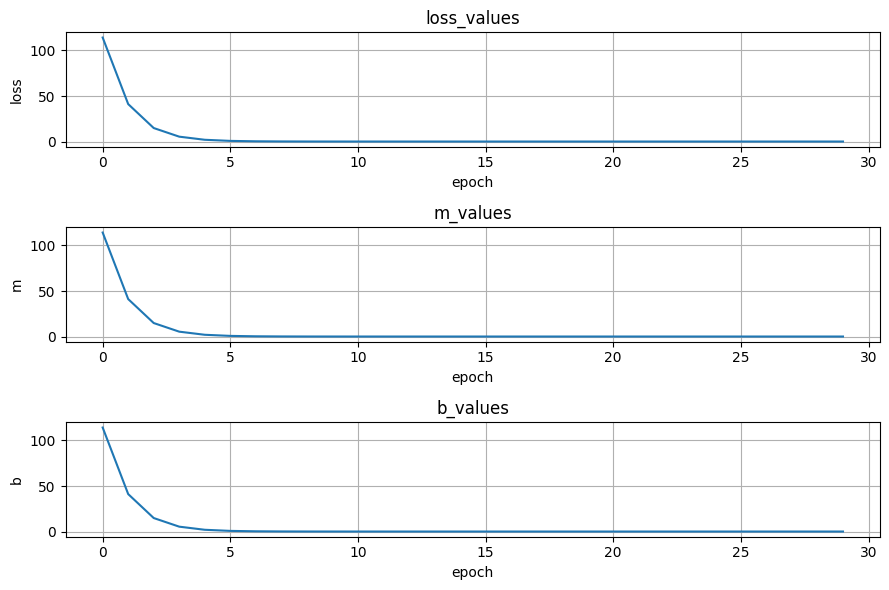

In [21]:
val = ['loss_values', 'm_values', 'b_values']

fig, axs = plt.subplots(3,1,figsize = (9,6))
for i in range(3):
  axs[i].plot(loss_values)
  axs[i].set_title(val[i])
  axs[i].set_xlabel('epoch')
  axs[i].set_ylabel(val[i][:-7])
  axs[i].grid()

plt.tight_layout()
plt.show()

11. graph_linear_regression_mse 함수를 활용해서 loss landscape를 시각화하세요.

<ipython-input-25-41b8a033277a>:79: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 11


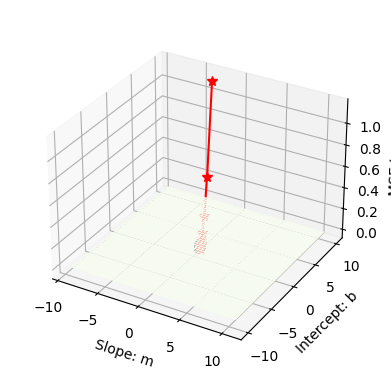

In [26]:
fig , ax = graph_linear_regression_mse(normed_height, normed_wingspan, trajectory)
plt.show()

12. 데이터의 산점도, 이상적인 선형 회귀 모델, 직접 구한 선형 회귀 모델을 시각화하세요.

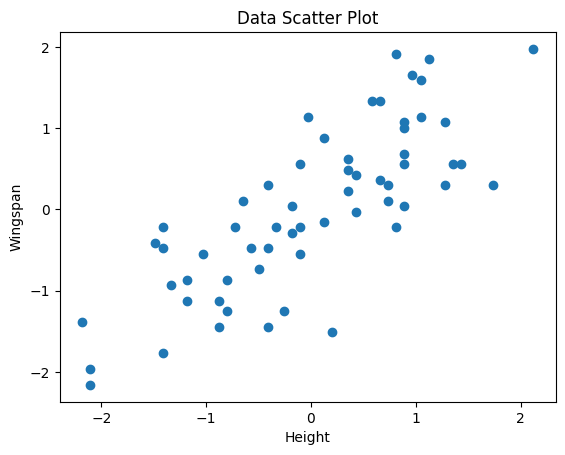

In [27]:
plt.scatter(normed_height, normed_wingspan)
plt.xlabel('Height')
plt.ylabel('Wingspan')
plt.title('Data Scatter Plot')
plt.show()

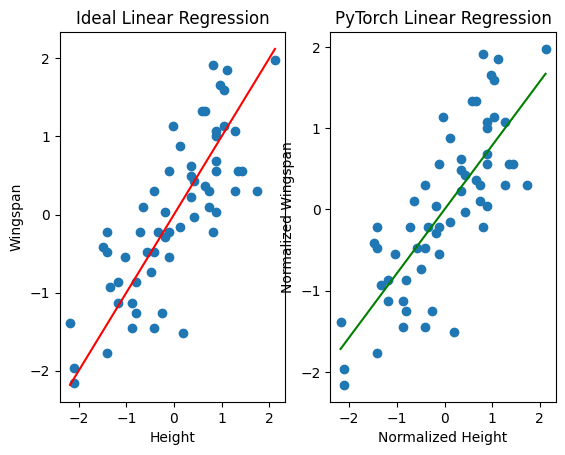

In [29]:
mv, bv = ordinary_least_squares(normed_height.detach().numpy(), normed_height.detach().numpy())

plt.subplot(121)
x_values = np.linspace(normed_height.min(), normed_height.max(), 1000)
y_values_ols = mv * x_values + bv
plt.scatter(normed_height, normed_wingspan)
plt.plot(x_values, y_values_ols, color = 'red')
plt.xlabel('Height')
plt.ylabel('Wingspan')
plt.title('Ideal Linear Regression')

plt.subplot(122)
y_values_pytorch = model.parameters()[0].item() * x_values + model.parameters()[1].item()
plt.scatter(normed_height, normed_wingspan)
plt.plot(x_values, y_values_pytorch, color = 'green')
plt.xlabel('Normalized Height')
plt.ylabel('Normalized Wingspan')
plt.title('PyTorch Linear Regression')
plt.show()

13. 우리가 얻은 모델은, $\bar{x}$, $\bar{y}$를 각각 관측된 키와 윙스팬 평균, $Std[x]$, $Std[y]$를 관측된 키와 윙스팬 표준편차라고 할 때, $\hat{x} = \frac{x-\bar{x}}{Std[x]}$,$\hat{y} = \frac{y-\bar{y}}{Std[y]}$ 의 관계를 $\hat{y}=m\hat{x}+b$로 설명하는 모델입니다. 표준화된 데이터에 대한 모델과 사용한 데이터의 평균, 표준편차를 알고 있을 때, 새로운 키를 입력하면 예상되는 윙스팬 값을 바로 반환해주는 함수를 작성하세요.

In [30]:
def processed_predictions(
    model,
    new_x,
    height_mean=height.mean(),
    height_std=height.std(),
    wingspan_mean=wingspan.mean(),
    wingspan_std=wingspan.std(),
):

    # x를 이용하여 x hat를 구하고, 모델을 통해 y hat를 구한 후, 다시 y hat를 y로 바꾸기
    if isinstance(new_x, torch.Tensor):
        new_x = new_x.detach().numpy()

    x_hat = (new_x - height_mean) / height_std # 표준화된 키 계산
    x_hat_tensor = torch.tensor(x_hat, dtype = torch.float32) # 텐서로 변환
    y_hat = model(x_hat_tensor).detach().numpy()# 표준화된 키에 대한 예상 윙스팬 계산
    y = y_hat * wingspan_std + wingspan_mean# 표준화 되돌리기

    return y

14. height의 최솟값과 최댓값 사이에서 1000개의 점을 생성하여 x 변수에 저장하세요. processed_predictions 함수를 사용하여 y 변수의 예측값을 구하세요.

In [31]:
x = np.linspace(height.min(), height.max(), 1000)
y = processed_predictions(model, x)

y[:10]

array([76.211975, 76.22509 , 76.23821 , 76.25133 , 76.26445 , 76.277565,
       76.29069 , 76.3038  , 76.316925, 76.33004 ], dtype=float32)

In [32]:
x[:10]

array([70.75      , 70.76401401, 70.77802803, 70.79204204, 70.80605606,
       70.82007007, 70.83408408, 70.8480981 , 70.86211211, 70.87612613])

15. 원래 데이터의 산점도를 그리고, 학습된 모델의 예측 결과와 이상적인 선형 회귀 모델을 같은 그래프에 표시하세요.

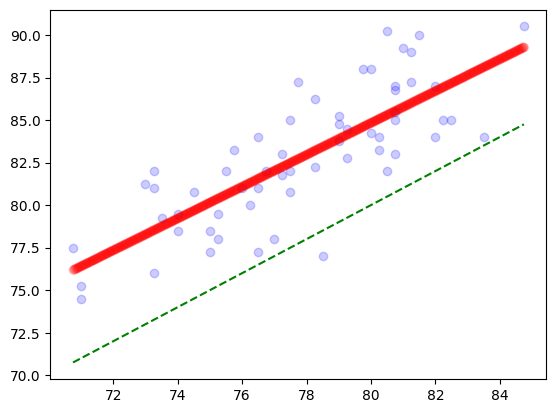

In [34]:
x_values = np.linspace(height.min(), height.max(), 1000)
y_values_ols = mv * x_values + bv

plt.scatter(height, wingspan,label = 'Original Data', color = 'blue', alpha = 0.2)
plt.scatter(x,y,label = 'Predicted Data', color = 'red', alpha = 0.1)
plt.plot(x, y_values_ols, label = 'Ideal Linear Regression', color = 'green' , linestyle = '--')

plt.show()